# Functional Autoencoder Clustering on Real Datasets
---
This notebook performs functional clustering using an autoencoder model. It loads a UCR time series dataset, preprocesses it into functional form, computes pairwise distances, constructs a similarity graph, trains a functional autoencoder (FAE), and evaluates the clustering performance using AMI and ARI metrics.

## 1. Import Required Libraries

In [1]:
import numpy as np
from aeon.datasets import load_classification
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import time

# Import custom modules for functional autoencoder clustering
from FAEclust import (
    smoothing_features,
    bspline_basis,
    rescale,
    TimeSeriesDistance,
    NearestNeighborsOpt,
    FunctionalAutoencoder,
)

## 2. Load and Preprocess Dataset
Load a UCR dataset, standardised it for stability, and extract labels.

In [2]:
start = time.time()
dataset_name = 'Plane'
X, y = load_classification(dataset_name)

# Standardise data and format labels
X, y = rescale(np.array(X), y, dataset_name)

Plane: Shape of X = (210, 1, 144)


## 3. Compute Pairwise Distance Matrix
Use FastDTW to compute pairwise distances between time series.

In [3]:
n_samples, n_features, n_timesteps = X.shape
tsd = TimeSeriesDistance(X, metric='fastdtw', n_jobs=-1)
D = tsd.compute_distances()

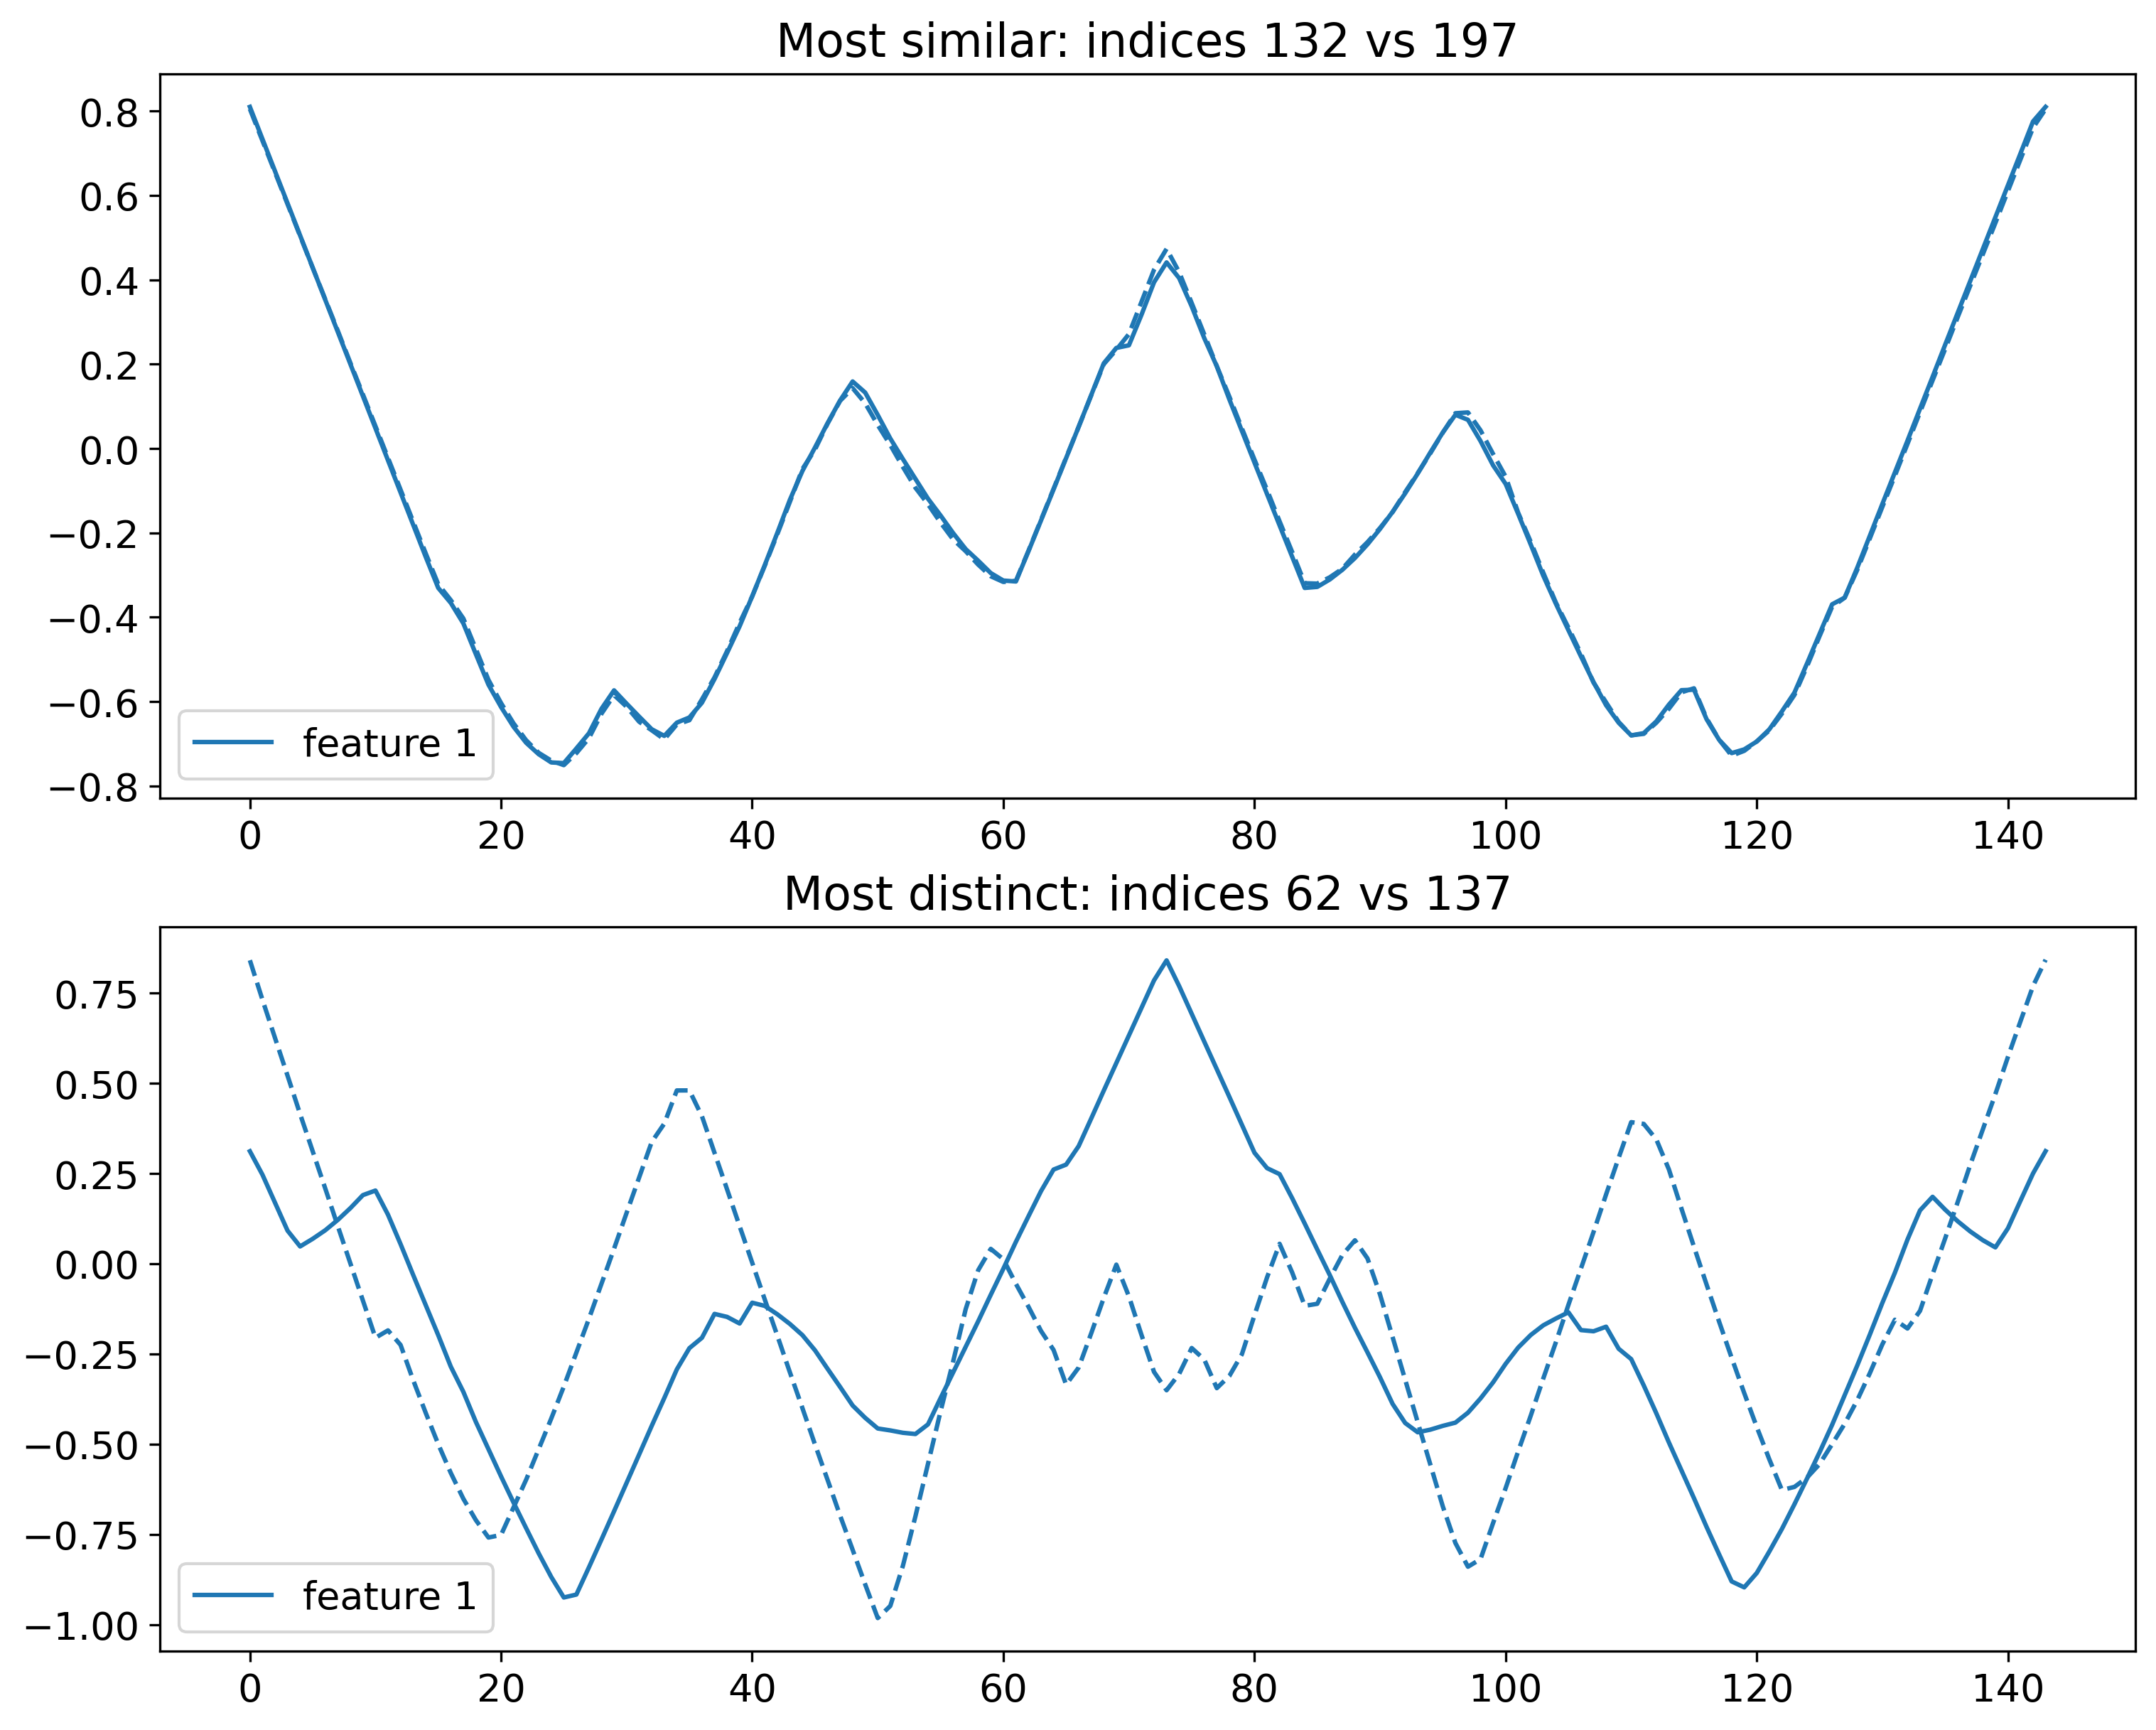

In [4]:
tsd.plot_extremes()    # plots the most similar and most dissimilar time series data

## 4. Build Nearest Neighbor Graph and Similarity Matrix

In [5]:
opt = NearestNeighborsOpt(D)
m = opt.estimate_optimal_m(method='avg_distance', max_m=n_samples-1)
print(f"Optimal m (avg_distance): {m}")
neighbors_dict = opt.get_nearest_neighbors(opt_m=m)
sim_matrix = opt.compute_similarity(neighbors_dict)

Optimal m (avg_distance): 30


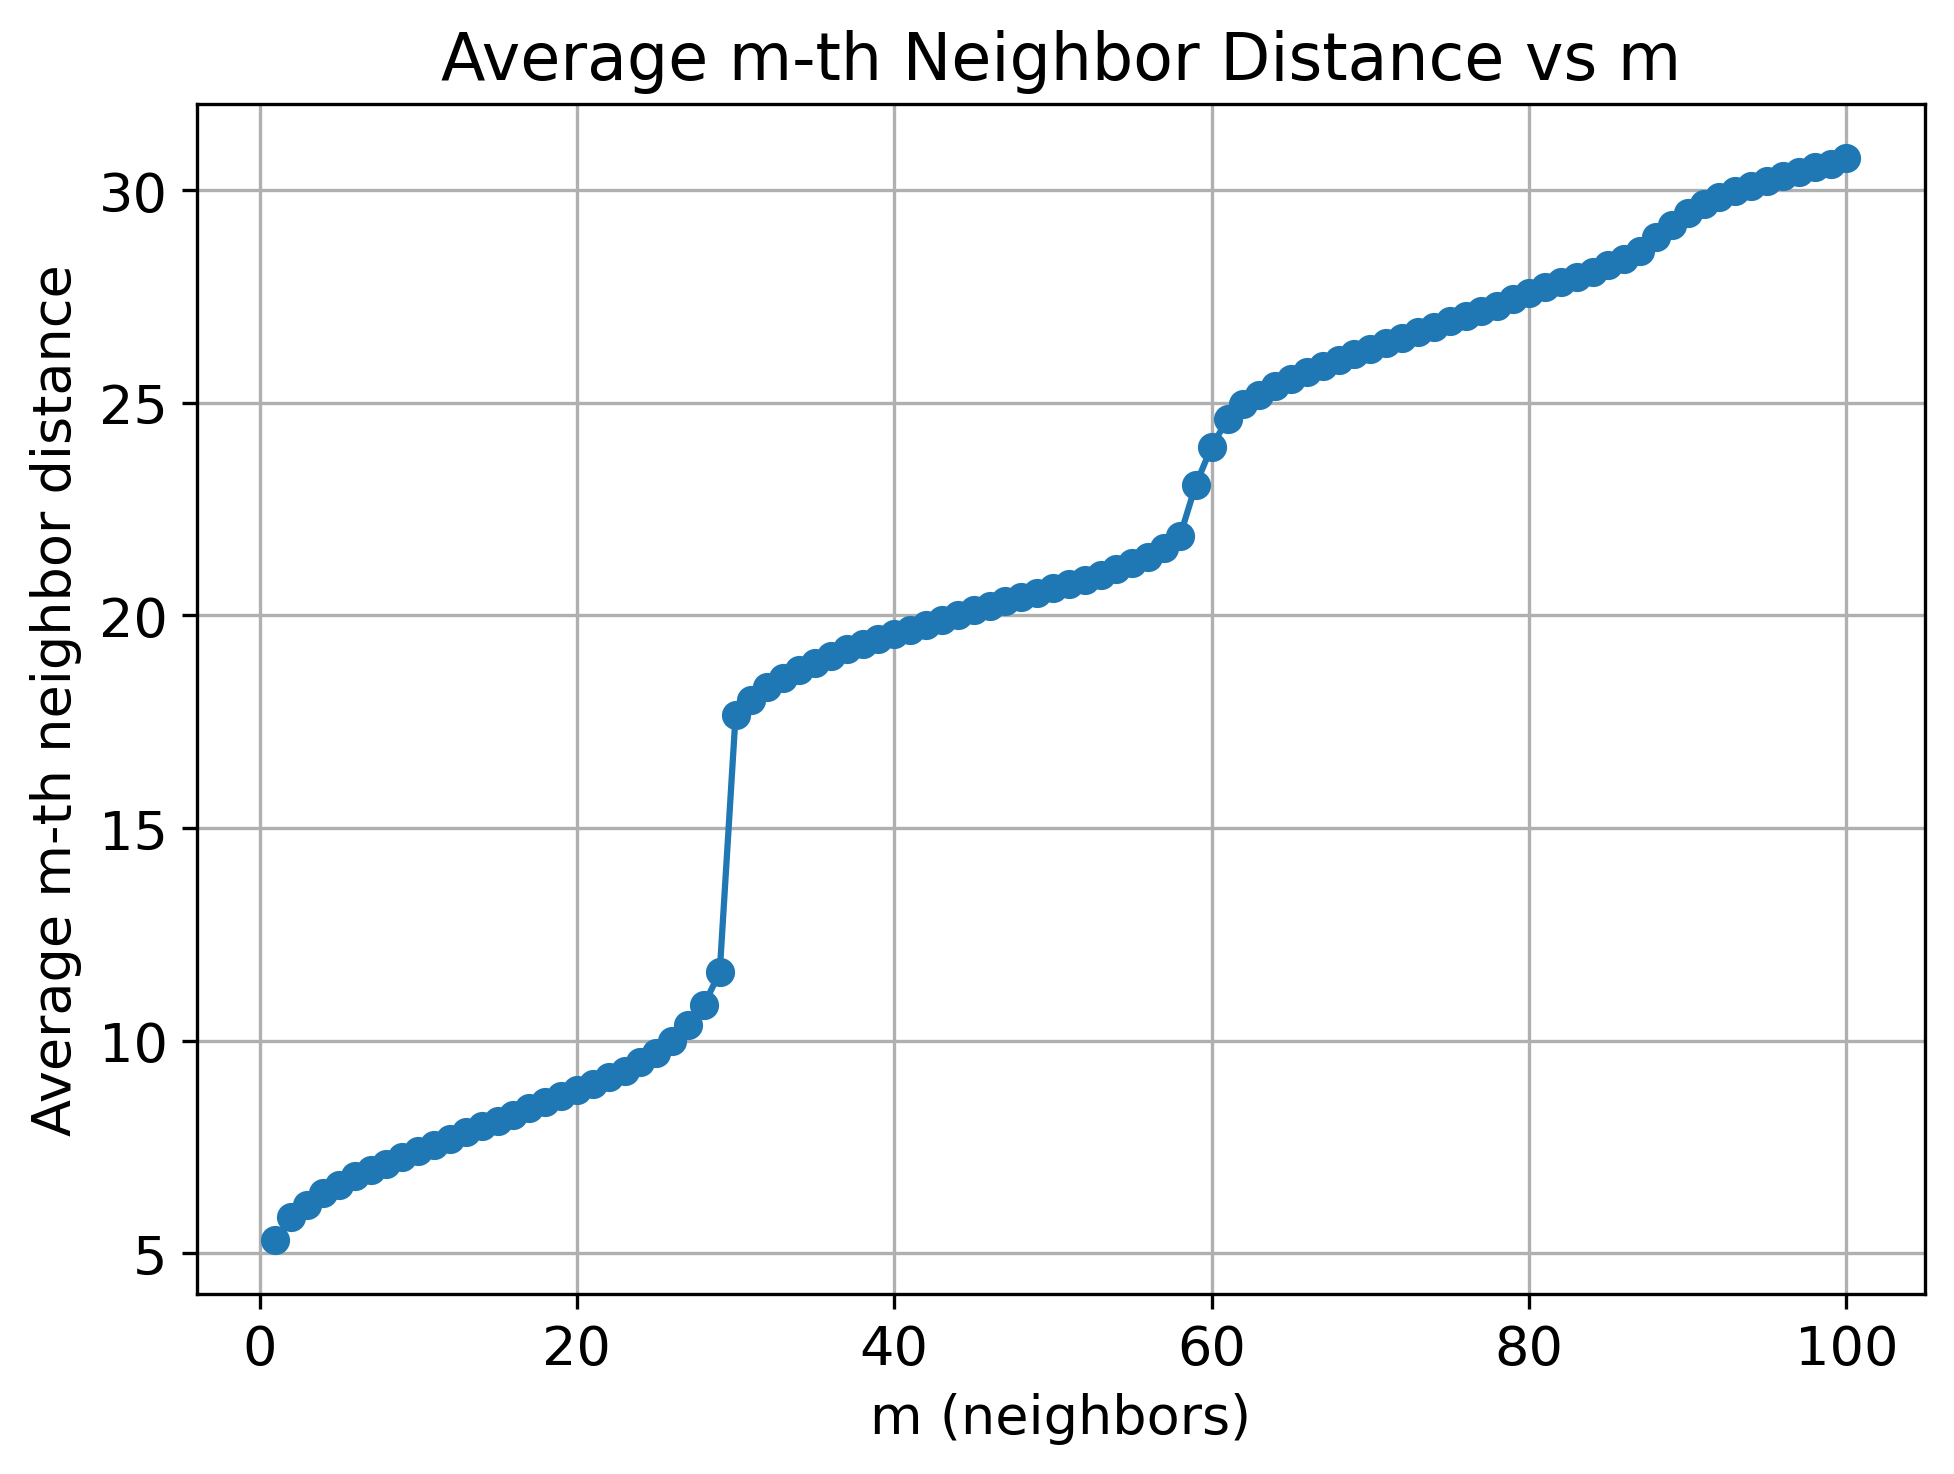

In [6]:
opt.plot_average_mth_distances(max_m = 100)     # plots the mth average distance showing sharp jump at m = 30

## 5. Smooth Features Using B-Splines

In [7]:
m_basis = 50
dis_p = 300
t = np.linspace(0, 1, dis_p)
coeffs, curves, basis_smoothing = smoothing_features(
    X, m=m_basis, dis_p=dis_p, fit='bspline')

end = time.time()
print(f'{dataset_name}: pre-processing Time = {end - start:.2f} s')

Plane: pre-processing Time = 50.29 s


## 6. Train Functional Autoencoder (FAE)
Define the network architecture, regularisation, and training parameters, then train the model.

In [8]:
p = n_features
layers = [32, 16, 8, 16, 32, 32, 32]
l_basis = 50
basis_input = bspline_basis(num_basis=l_basis)
lambda_e, lambda_d, lambda_c = 0.5, 0.05, 0.5
epochs = 100
learning_rate = 1e-3
batch_size = 16

FAE_model = FunctionalAutoencoder(
    p, layers, l=l_basis, m=m_basis,
    basis_smoothing=basis_smoothing,
    basis_input=basis_input,
    lambda_e=lambda_e, lambda_d=lambda_d, lambda_c=lambda_c,
    t=t, sim_matrix=sim_matrix
)

FAE_model.model_summary()

start = time.time()
FAE_model.train(
    coeffs,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    neighbors_dict=neighbors_dict,
    sim_matrix=sim_matrix
)
end = time.time()
print(f'{dataset_name}: network training Time = {end - start:.2f} s')

Functional Autoencoder:
Layer (type)              Shape                          Param #   
wfn                       (32, 1, 50)                    1600      
bfn                       (32,)                          32        
W_enc_1                   (32, 16)                       512       
b_enc_1                   (16,)                          16        
W_enc_2                   (16, 8)                        128       
b_enc_2                   (8,)                           8         
W_dec_2                   (8, 16)                        128       
b_dec_2                   (16,)                          16        
W_dec_1                   (16, 32)                       512       
b_dec_1                   (32,)                          32        
Wfn1                      (32, 32, 50)                   51200     
Bfn1                      (32, 50)                       1600      
Wfn2                      (32, 32, 50)                   51200     
Bfn2                    

## 7. Evaluate Clustering Performance

In [9]:
S, labels = FAE_model.predict(coeffs, batch_size=batch_size)
ami = adjusted_mutual_info_score(y, labels)
ari = adjusted_rand_score(y, labels)

print(f'AMI score: {ami:.4f}')
print(f'ARI score: {ari:.4f}')
print(f'Number of clusters predicted: {len(np.unique(labels))}')

AMI score: 0.9287
ARI score: 0.8275
Number of clusters predicted: 7


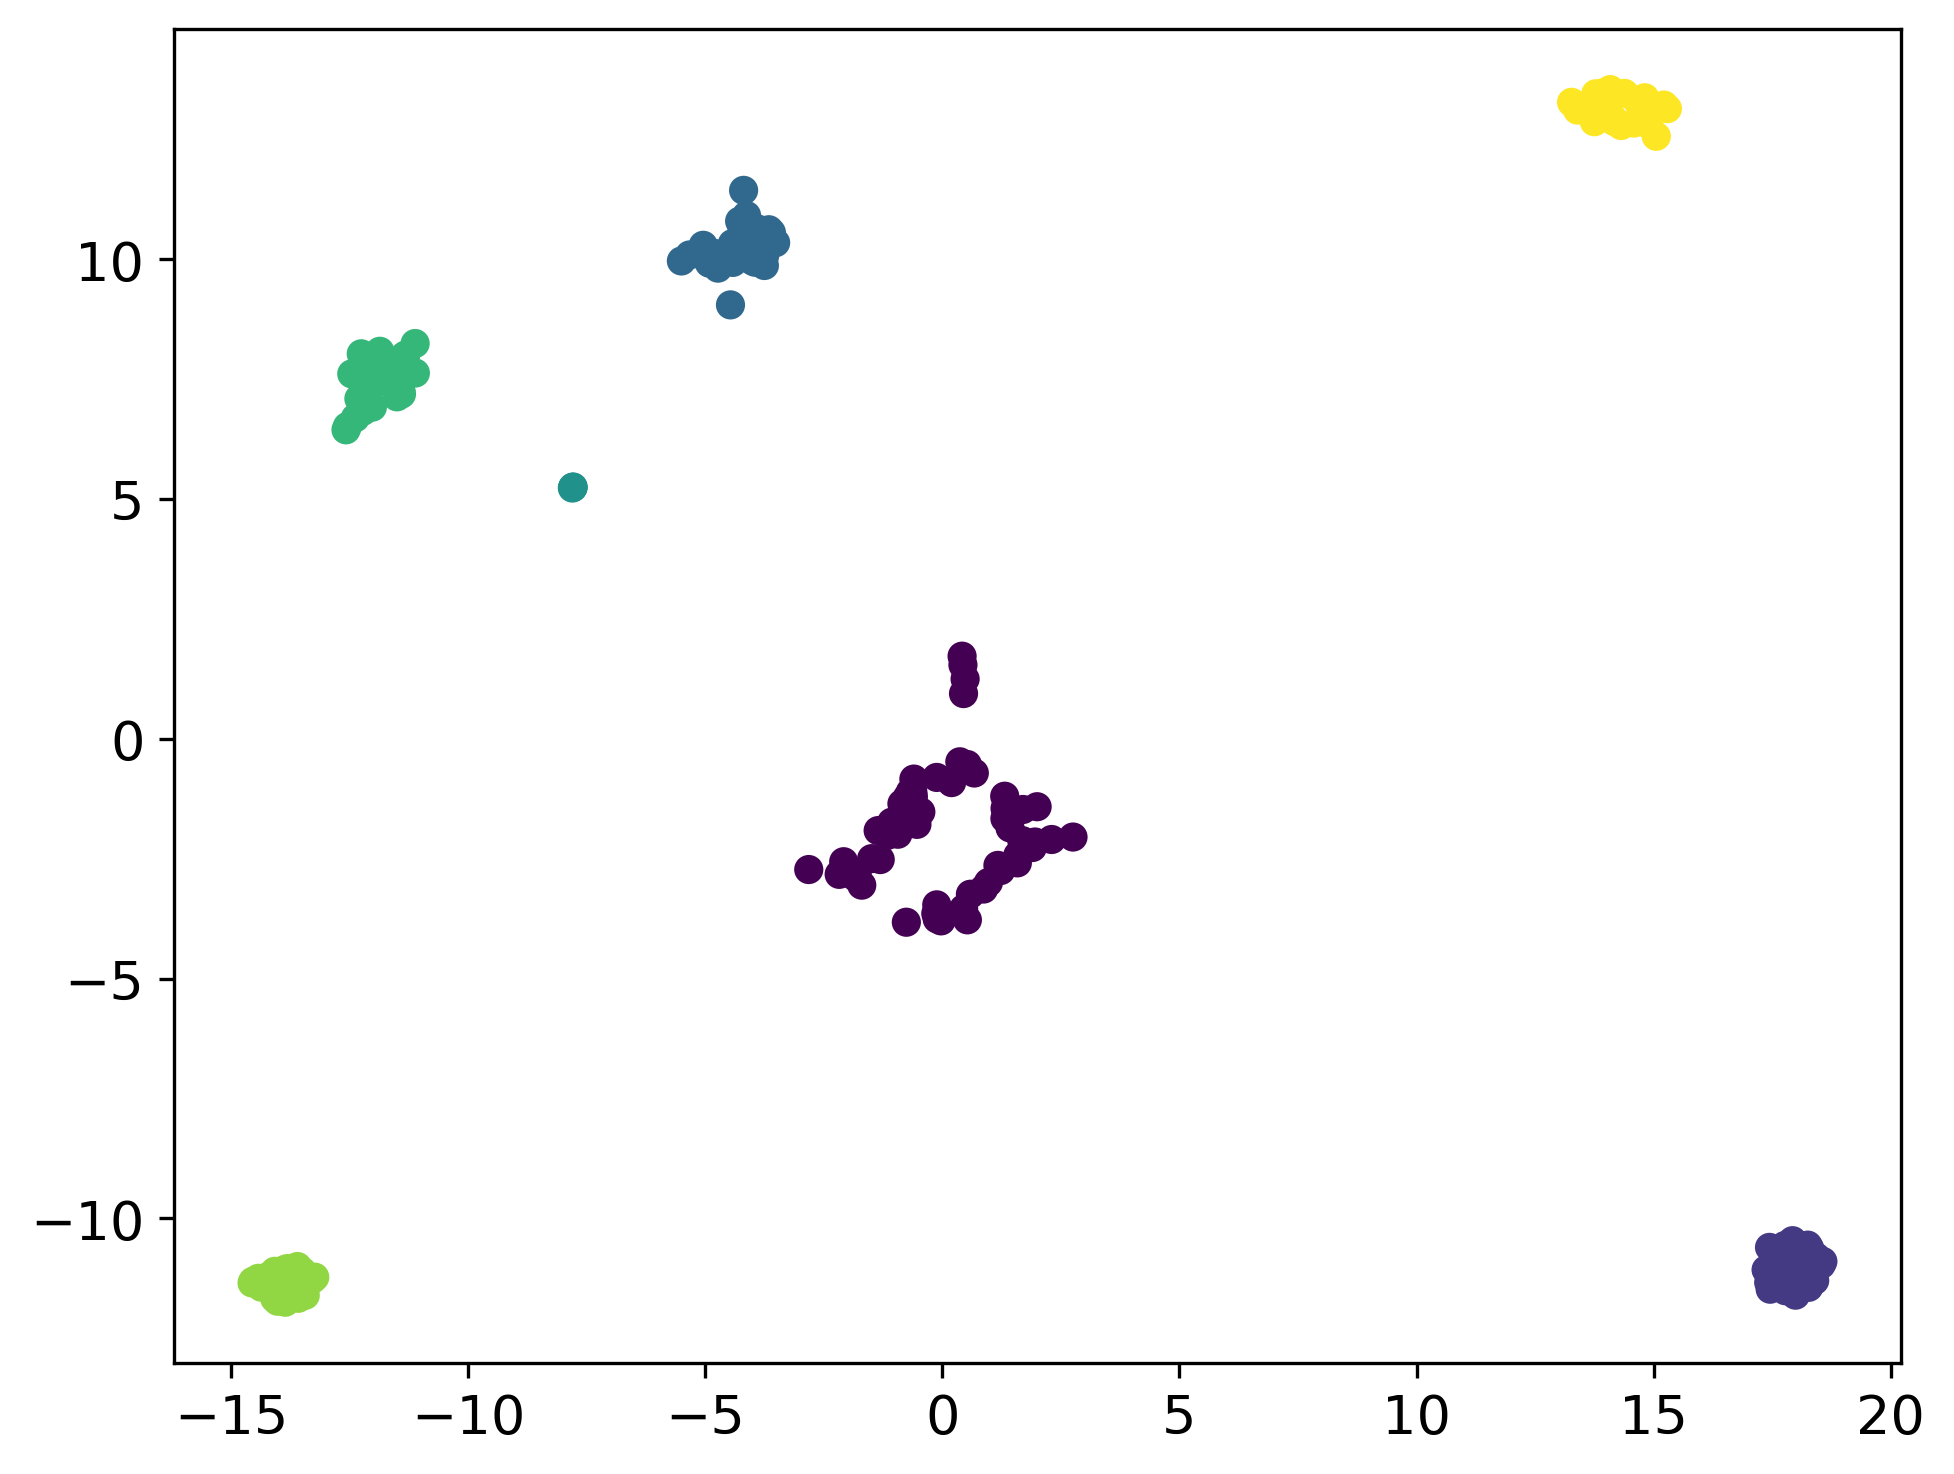

In [10]:
# to visualise the latent representations
# import t-SNE to plot the latent representation in a 2D scatter plot
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
s = np.min(layers)
tsne = TSNE(n_components=2)
K = tsne.fit_transform(S)
plt.scatter(K[:,0], K[:,1], c=labels)
plt.show()